In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

MAZE_FILE_NAME = "../Maze_6.png"
ROBOT_FILE_NAME = "../Robot_6.png"
IMAGE_LADYBUG_FILE_NAME = "../Ladybug_small.png"
MAP_FILE_NAME = "../MapBuilt.txt"

TRANSFORMED_MAZE = None

ROWS = 5
COLUMNS = 9

def showMaze(image):
    plt.figure(figsize = (COLUMNS,ROWS))
    plt.imshow(image)
    plt.show()
    
def round_up_x(pixel):
    if pixel < 400:
        return 0
    if pixel > 1000:
        return 1350
    
def round_up_y(pixel):
    if pixel <= 375:
        return 0
    if pixel > 375:
        return 750
    
def sift(img1, img2):
    dis = 0.3
    # Code modified from https://answers.opencv.org/question/175834/sift-feature-matches-coordinates/
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=1000)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    good = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < dis*n.distance:
            good.append(m)

    dst_pt = [ kp2[m.trainIdx].pt for m in good ]

    numPoints = 0
    sumX = 0
    sumY = 0
    for tup in dst_pt:
        sumX = sumX + tup[0]
        sumY = sumY + tup[1]
        numPoints = numPoints + 1
    
    if numPoints == 0:
        dis = dis + 0.1
        for i,(m,n) in enumerate(matches):
            if m.distance < dis*n.distance:
                good.append(m)

        dst_pt = [ kp2[m.trainIdx].pt for m in good ]
        for tup in dst_pt:
            sumX = sumX + tup[0]
            sumY = sumY + tup[1]
            numPoints = numPoints + 1

    endRow = sumY/numPoints//100
    endCol = sumX/numPoints//100        
    x = int(endRow)*100+50
    y = int(endCol)*100+50
    return y, x

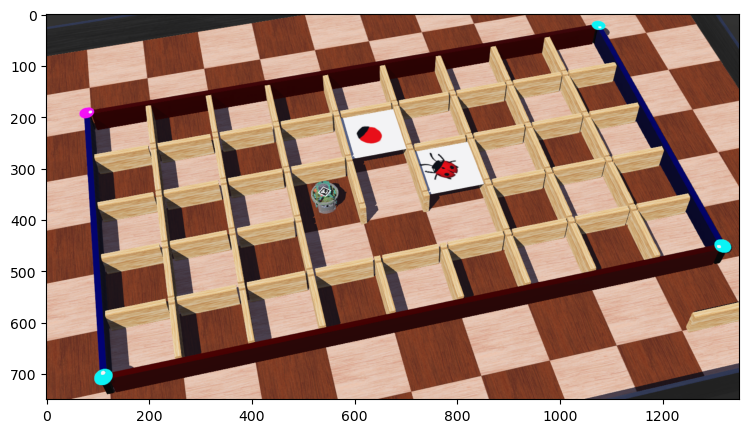

In [2]:
# PRINT OUT MAZE IN RGB
mazeImage = cv2.imread(MAZE_FILE_NAME)

imageRGB = cv2.cvtColor(mazeImage,cv2.COLOR_BGR2RGB)

showMaze(imageRGB)

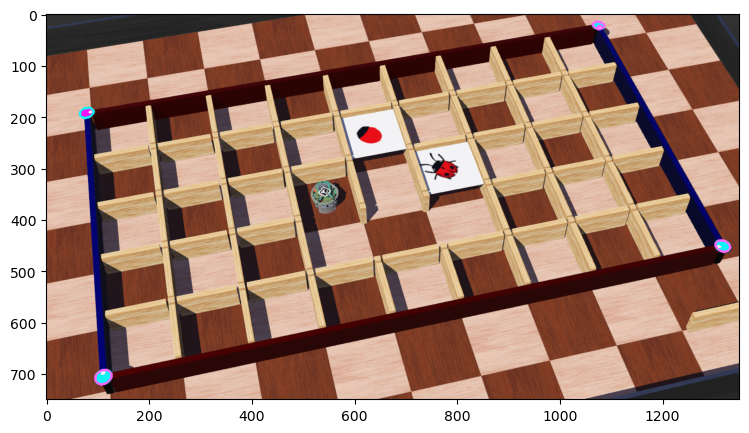

In [3]:
# IDENTIFY CORNERSTONES
imageHSV = cv2.cvtColor(mazeImage,cv2.COLOR_BGR2HSV)
flip = False

lowerBlue = np.array([25, 0, 234], dtype="uint8")
upperBlue = np.array([100, 255, 255], dtype="uint8")
maskBlue = cv2.inRange(imageHSV, lowerBlue, upperBlue)

lowerPink = np.array([150, 0, 240], dtype="uint8")
upperPink = np.array([150, 240, 255], dtype="uint8")
maskPink = cv2.inRange(imageHSV, lowerPink, upperPink)

k = np.ones((3,3),np.uint8)
maskB = cv2.erode(maskBlue,k,iterations=1)
blueContours = cv2.findContours(maskB, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
blueContours = blueContours[0] if len(blueContours) == 2 else blueContours[1]

corners = []

for c in blueContours:
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(approx) > 5:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            corners.append([cX, cY])
            cv2.drawContours(imageRGB, [c], -1, (255, 102, 255), 3)
        
pinkContours = cv2.findContours(maskPink, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
pinkContours = pinkContours[0] if len(pinkContours) == 2 else pinkContours[1]

for c in pinkContours:
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(approx) > 5:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.drawContours(imageRGB, [c], -1, (21,243,245), 3)        
            if cX < 400:
                flip = True
        
showMaze(imageRGB)

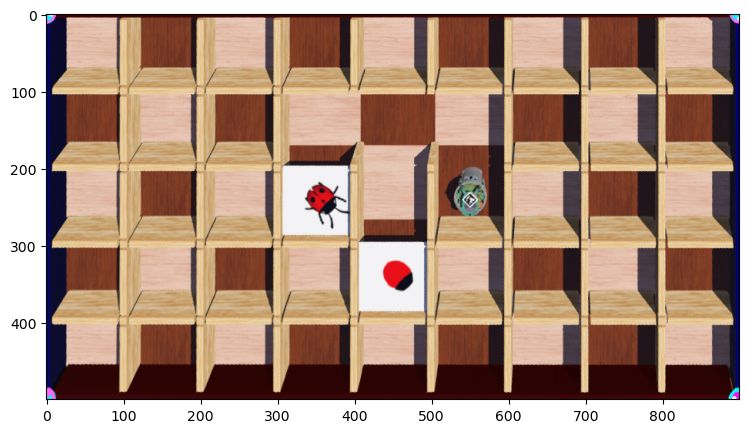

In [4]:
# PERSPECTIVE TRANSFORM
pts1 = np.float32([[corners[0][0],corners[0][1]],
                   [corners[1][0],corners[1][1]],
                   [corners[2][0],corners[2][1]],
                   [cX,cY]]) # four points on the first image
pts2 = np.float32([[0,0],[0,0],[0,0],[0,0]])
if flip == False:
    pts2 = np.float32([[round_up_x(corners[0][0])*900/1350,round_up_y(corners[0][1])*500/750],
                       [round_up_x(corners[1][0])*900/1350,round_up_y(corners[1][1])*500/750],
                       [round_up_x(corners[2][0])*900/1350,round_up_y(corners[2][1])*500/750],
                       [round_up_x(cX)*900/1350,round_up_y(cY)*500/750]]) # four points on the second image
if flip == True:
    pts2 = np.float32([[900-round_up_x(corners[0][0])*900/1350,500-round_up_y(corners[0][1])*500/750],
                       [900-round_up_x(corners[1][0])*900/1350,500-round_up_y(corners[1][1])*500/750],
                       [900-round_up_x(corners[2][0])*900/1350,500-round_up_y(corners[2][1])*500/750],
                       [900-round_up_x(cX)*900/1350,500-round_up_y(cY)*500/750]]) # four points on the second image

H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix

TRANSFORMED_MAZE = cv2.warpPerspective(imageRGB, H, (900,500))
showMaze(TRANSFORMED_MAZE)

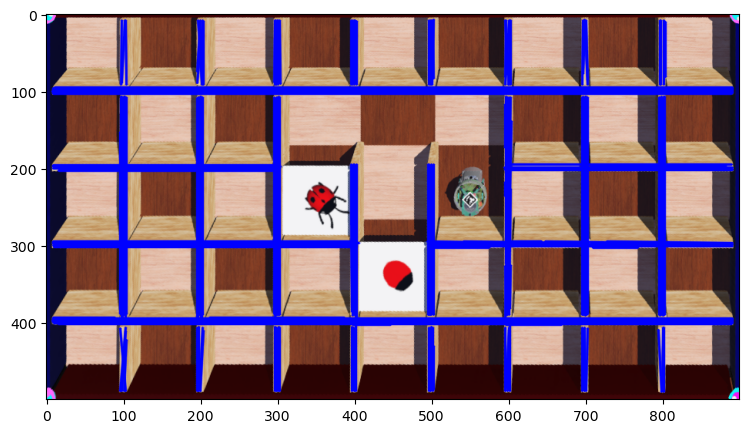

In [5]:
# DETECT INTERNAL WALLS
lower = np.array([17, 0, 221])
upper = np.array([19, 255, 255])
transformedMazeHSV = cv2.cvtColor(TRANSFORMED_MAZE,cv2.COLOR_RGB2HSV)
mask = cv2.inRange(transformedMazeHSV, lower, upper)

walls = cv2.HoughLinesP(mask, 1, np.pi / 180, 50, None, 10, 10)

if walls is not None:
    for i in range(0, len(walls)):
        lin = walls[i][0]
        cv2.line(TRANSFORMED_MAZE, (lin[0], lin[1]), (lin[2], lin[3]), (0,0,255), 2, cv2.LINE_AA)

showMaze(TRANSFORMED_MAZE)

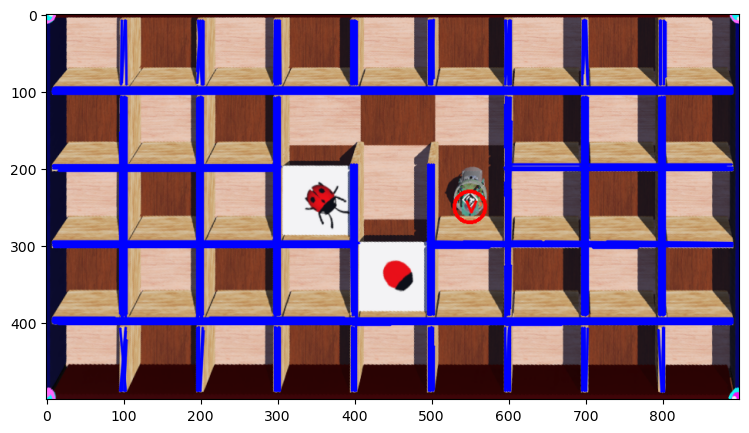

In [6]:
# LOCATION AND HEADING OF ROBOT
robotImage = cv2.imread(ROBOT_FILE_NAME)          # queryImage
robotRGB = cv2.cvtColor(robotImage,cv2.COLOR_BGR2RGB)

img1 = cv2.imread(ROBOT_FILE_NAME,cv2.IMREAD_GRAYSCALE)          # queryImage
img2 = cv2.cvtColor(TRANSFORMED_MAZE, cv2.COLOR_RGB2GRAY)

cx, cy = sift(img1, img2)

robotMaze = cv2.circle(TRANSFORMED_MAZE, (cx, cy), 20, (255,0,0), 3)

# Load the predefined dictionary
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
# Initialize the detector parameters using default values
parameters =  cv2.aruco.DetectorParameters_create()
# Detect the markers in the image
markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(robotRGB, dictionary, parameters=parameters)

heading = "v"
if max(markerCorners[0][0][0][0], markerCorners[0][0][1][0], markerCorners[0][0][2][0], markerCorners[0][0][3][0]) == markerCorners[0][0][0][0]:
    heading = ">"
if min(markerCorners[0][0][0][0], markerCorners[0][0][1][0], markerCorners[0][0][2][0], markerCorners[0][0][3][0]) == markerCorners[0][0][0][0]:
    heading = "<"
if min(markerCorners[0][0][0][1], markerCorners[0][0][1][1], markerCorners[0][0][2][1], markerCorners[0][0][3][1]) == markerCorners[0][0][0][1]:
    heading = "^"
if max(markerCorners[0][0][0][1], markerCorners[0][0][1][1], markerCorners[0][0][2][1], markerCorners[0][0][3][1]) == markerCorners[0][0][0][1]:
    heading = "v"

if flip == True:
    if heading == "v":
        heading = "^"
    if heading == "^":
        heading = "v"
    if heading == ">":
        heading = "<"
    if heading == "<":
        heading = ">"
    
robotMaze= cv2.putText(robotMaze, heading, (cx-6, cy+7), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)

showMaze(robotMaze)

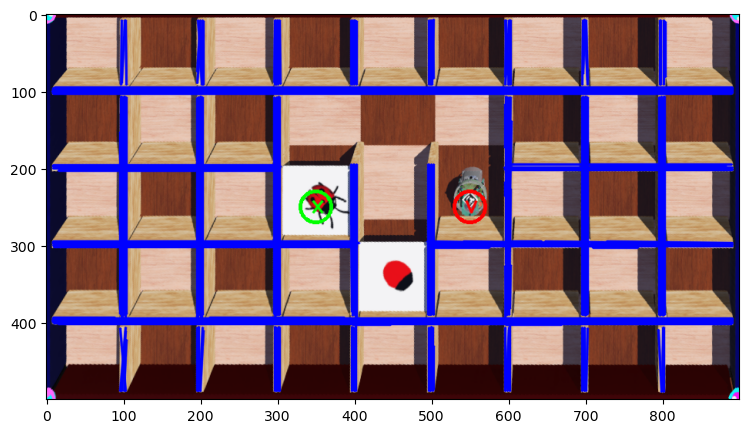

In [7]:
img1 = cv2.imread(IMAGE_LADYBUG_FILE_NAME,cv2.IMREAD_GRAYSCALE)          # queryImage
img2 = cv2.cvtColor(robotMaze, cv2.COLOR_RGB2GRAY)

cxBug, cyBug = sift(img1, img2)
finalMaze = cv2.circle(robotMaze, (cxBug, cyBug), 20, (0, 255, 0), 3)
finalMaze = cv2.putText(finalMaze, 'x', (cxBug-6, cyBug+7), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

showMaze(finalMaze)

In [8]:
wallCheck = list(range(70,131))
row = list(range(0,401,100))
column = list(range(0,801,100))

finalMazeRGB = cv2.cvtColor(finalMaze,cv2.COLOR_RGB2HSV) 
lower = np.array([120, 255, 255])
upper = np.array([120, 255, 255])
finalMaze = cv2.inRange(finalMazeRGB, lower, upper)

f = open(MAP_FILE_NAME, "w")
f.write(" --- --- --- --- --- --- --- --- --- ")

for i in row:
    f.write("\n")
    f.write("|") 
    for j in column:
        if cx in range(j,j+100) and cy in range(i,i+100):
            f.write(" ")
            f.write(heading)
            f.write(" ")
        elif cxBug in range(j,j+100) and cyBug in range(i,i+100):
            f.write(" x ")
        else:
            f.write("   ")
        if j == 800:
            f.write("|")
        else:
            for k in wallCheck:
                if finalMaze[i+50,j+k] == 255:
                    d = True
                    break
                else:
                    d = False
            if d == True:
                f.write("|")
            else:
                f.write(" ")
    f.write("\n")
    if i == 400:
        break
    f.write(" ")
    for j in column:
        for k in wallCheck:
            if finalMaze[i+k,j+50] == 255:
                d = True
                break
            else:
                d = False
        if d == True:
            f.write("--- ")
        else:
            f.write("    ")
f.write(" --- --- --- --- --- --- --- --- --- \n")
f.close()